In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from scipy import stats

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import Callback

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import cross_val_score, train_test_split

%matplotlib inline

Using TensorFlow backend.


In [0]:
df = pd.read_csv('winequality-red.csv', sep=';').append(pd.read_csv('winequality-white.csv', sep=';'), ignore_index=True)

In [0]:
df.loc[df['quality'] < 6, 'rating'] = 0
df.loc[df['quality'] >= 6, 'rating'] = 1

In [0]:
df_new = df[(np.abs(stats.zscore(df)) <= 3).all(axis=1)]

In [0]:
Y = df['rating']

df_new = df.drop(['quality', 'rating'], axis=1)

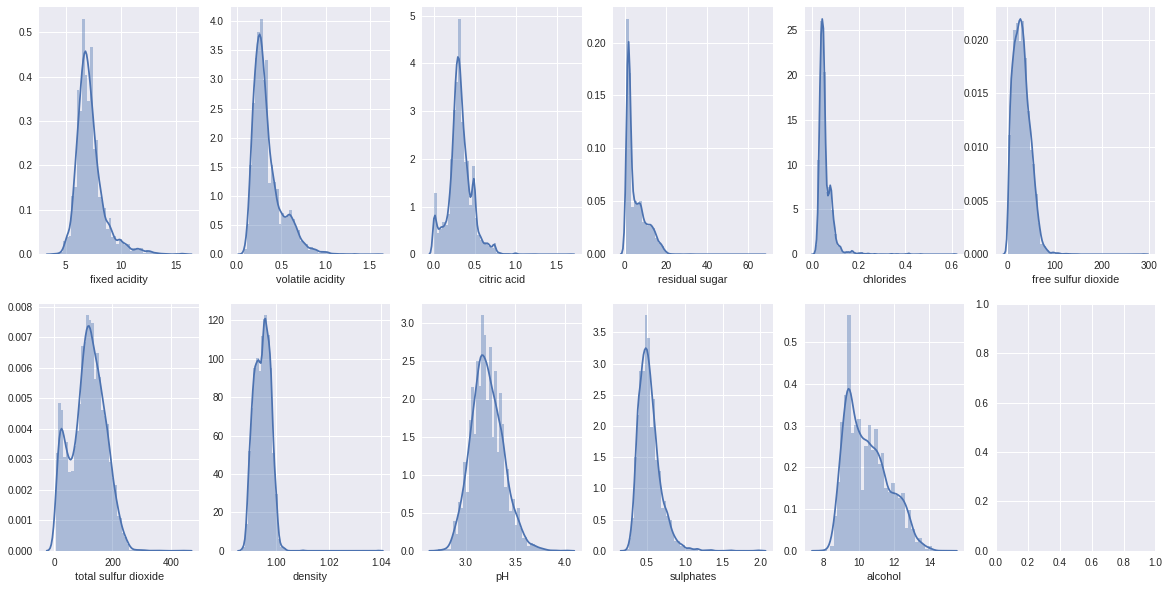

In [7]:
fig, axes = plt.subplots(ncols=6, nrows=2, figsize=(20,10))
axes = axes.flatten()
index = 0


for k,v in pd.DataFrame(df_new).items():
  sb.distplot(v, ax=axes[index])
  index += 1

In [9]:
scaler = StandardScaler()

df_new = scaler.fit_transform(df_new)

X = df_new[:, 0:11]
Y = Y.reshape(-1, 1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  


In [10]:
print(X_train.shape)
print(X_test.shape)

(5522, 11)
(975, 11)


In [11]:
print(Y_train[0:5])
print(Y_test[0:5])

[[0.]
 [0.]
 [0.]
 [1.]
 [1.]]
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]]


In [0]:
class Metrics(Callback):
  def on_train_begin(self, logs={}):
    self.f1s = []
    self.recalls= []
    self.precisions = []
    
  def on_epoch_end(self, epoch, logs={}):
    predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
    targ = self.validation_data[1]
    _f1 = f1_score(targ, predict, average='micro')
    _recall = recall_score(targ, predict, average='micro')
    _precision = precision_score(targ, predict, average='micro')
    self.f1s.append(_f1)
    self.recalls.append(_recall)
    self.precisions.append(_precision)
    
    print (" f1: %f val | precision: %f | recall %f" % (_f1, _precision, _recall))
    return
  
metrics = Metrics()

In [0]:
from keras.optimizers import Adam
def model(X_train, Y_train, X_test, Y_test):
  global network_history
  model = Sequential()
  model.add(Dense(28, input_shape=(11,), activation='relu'))
  model.add(Dropout(0.1))
  model.add(Dense(18, activation='relu'))
  model.add(Dense(1, activation='sigmoid'))
  
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

  network_history = model.fit(X_train, Y_train, batch_size=48, epochs=300, shuffle=True, verbose=1)

  score = model.evaluate(X_test, Y_test)

  print("Test score ", score[0])
  print("Test accuracy ", score[1])

  return model

In [15]:
model = model(X_train, Y_train, X_test, Y_test)

Epoch 1/300
5522/5522 [==============================] - 1s 167us/step - loss: 0.6284 - acc: 0.6463
Epoch 2/300
5522/5522 [==============================] - 1s 117us/step - loss: 0.5401 - acc: 0.7311
Epoch 3/300
5522/5522 [==============================] - 1s 125us/step - loss: 0.5204 - acc: 0.7419
Epoch 4/300
5522/5522 [==============================] - 1s 130us/step - loss: 0.5126 - acc: 0.7454
Epoch 5/300
5522/5522 [==============================] - 1s 132us/step - loss: 0.5087 - acc: 0.7439
Epoch 6/300
5522/5522 [==============================] - 1s 128us/step - loss: 0.5058 - acc: 0.7535
Epoch 7/300
5522/5522 [==============================] - 1s 131us/step - loss: 0.5058 - acc: 0.7499
Epoch 8/300
5522/5522 [==============================] - 1s 134us/step - loss: 0.5013 - acc: 0.7562
Epoch 9/300
5522/5522 [==============================] - 1s 133us/step - loss: 0.5009 - acc: 0.7564
Epoch 10/300
5522/5522 [==============================] - 1s 130us/step - loss: 0.5005 - acc: 0.7521

In [0]:
def plot_history(network_history,title='Loss and accuracy'):
    plt.figure(figsize=(15,10))
    plt.subplot(211)
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(network_history.history['loss'])
    #plt.plot(network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.subplot(212)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(network_history.history['acc'])
    #plt.plot(network_history.history['val_acc'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

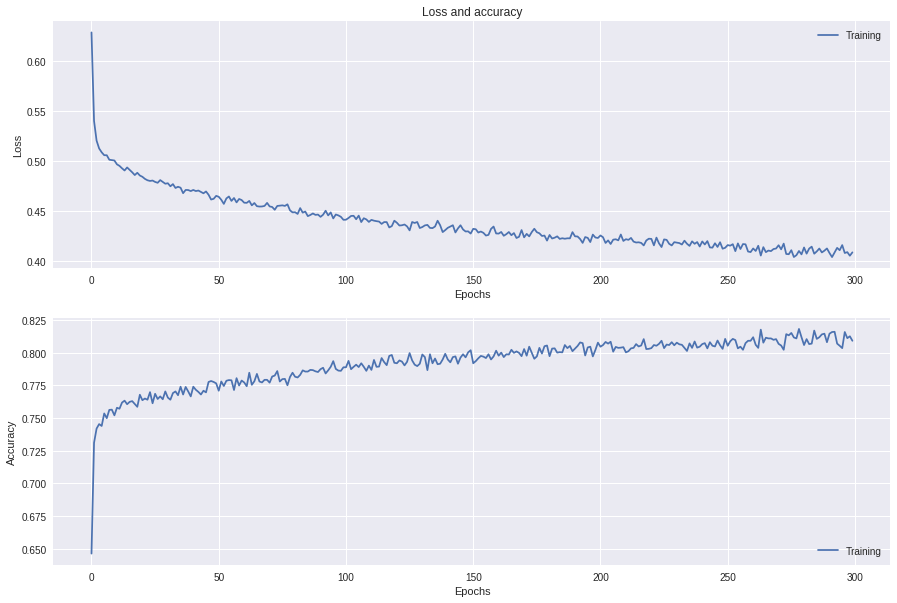

In [17]:
plot_history(network_history)

In [0]:
y_pred = model.predict(X_test)

In [19]:
y_pred[:10]

array([[0.7477036 ],
       [0.8827985 ],
       [0.6090215 ],
       [0.9388724 ],
       [0.23994106],
       [0.7659713 ],
       [0.77088916],
       [0.7554397 ],
       [0.9856333 ],
       [0.22627182]], dtype=float32)

In [20]:
Y_test[:10]

array([[0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.]])

In [22]:
confusion_matrix(Y_test, y_pred.round())

array([[217, 107],
       [ 97, 554]])

In [23]:
precision_score(Y_test, y_pred.round())

0.8381240544629349

In [24]:
recall_score(Y_test, y_pred.round())

0.8509984639016898

In [25]:
f1_score(Y_test, y_pred.round())

0.8445121951219511